In [1]:
# built-in modules
# 3-rd party modules
import pandas as pd
import numpy as np
# local modules
import scripts.footprint as fp


In [5]:
import importlib
importlib.reload(fp)


<module 'scripts.footprint' from 'c:\\Users\\phherigcoimb\\OneDrive\\Projects\\_gitRepo\\footprint_addon\\scripts\\footprint.py'>

# Read

from data

In [ ]:
from_cp = fp.fpData().read(
    'data', fp.get_data_from_url('https://citydata.icos-cp.eu/licence_accept?ids=%5B%22kbutdO3tisiqFQdtAfSjb6ow%22%5D', na_values=[-9999]
                                 )[:10],
    by='TIMESTAMP_END', **{'zm': 50, 'z0': 1, 'PBLH': 1000, 'latlon': (48.88514, 2.42222)},).agg()


Columns zm not found in data.
Columns z0 not found in data.
Columns PBLH not found in data.
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated


from data

In [ ]:
from_data = fp.fpData()
from_data.source = (pd.read_csv('sample/input/eddypro_FR-Rmv_full_output_2024-11-16T044017_adv.csv', skiprows=[0,2], na_values=[-9999])
           .rename(columns={'u_rot': 'WS', 'L': 'MO_LENGTH', 'u*': 'USTAR', 'wind_dir': "WD"}))
from_data.source['V_SIGMA'] = np.sqrt(from_data.source.v_var)
from_data.source['TIMESTAMP'] = pd.to_datetime(from_data.source['date'] + 'T' + from_data.source['time']).dt.strftime('%y%m%d%H%M')

from_data = fp.fpData().read('data', from_data.source,
    by='TIMESTAMP', **{'zm': 50, 'z0': 1, 'PBLH': 1000, 'latlon': (48.88514, 2.42222)},).agg()


from .tif

In [ ]:
from_tif = fp.fpData().read('tif', 'sample/output/from_data/', latlon=(48.88514, 2.42222)).agg()
from_tif.data['timestep'] = [np.int64(d.rsplit('.', 1)[0].rsplit('_', 1)[-1][2:]) for d in from_tif.data['timestep'].to_numpy()]


from .nc

In [ ]:
#'sample/output/data_to_nc/FR-Rmv_footprint_230215.nc', 'sample/input/paris_footprint_240430.nc'
from_nc = fp.fpData().read('nc', 'sample/input/paris_footprint_240430.nc').agg()


from .shp (not recommended as it interpolates the levels)

In [ ]:
from_shp = fp.fpData().read('shp', 'sample/output/from_tif/paris_footprint_2411151000.shp',
                            2411151000,
                            bounds= (from_tif.data.y.min().to_numpy(), 
                                     from_tif.data.y.max().to_numpy(), 
                                     from_tif.data.x.min().to_numpy(), 
                                     from_tif.data.x.max().to_numpy()),
                            shape=(from_tif.data.dims['y'], from_tif.data.dims['x']))

# Save

to .tif

In [ ]:
to_tif = fp.structuredData()

from_ = 'tif'

if from_ == 'data':
    # if from data
    to_tif.direct_path = 'sample/output/from_data/paris_footprint_{}.tif'
    to_tif.__dict__.update({k: v for k, v in from_data.items() if k in ['FP', 'dx', 'dy']})
    to_tif.FP = {d.strftime('%Y%m%d%H%M'): f for d, f in to_tif.FP.items()}

if from_ == 'nc':
    # if from nc
    to_tif.direct_path = 'sample/output/from_nc/paris_footprint_{}.tif'
    to_tif.__dict__.update({k: v for k, v in from_nc.items() if k in ['FP', 'dx', 'dy']})

for d, f in to_tif.FP.items():
    print(d, ' '*15, end='\r')    
    # Save tif
    fp.write_to_tif(f, to_tif.parameter.dx, to_tif.parameter.dy, to_tif.direct_path.format(d))


to .shp

In [84]:
from_tif

In [ ]:
to_shp = fp.structuredData()

from_ = 'tif'

if from_ == 'data':
    # if from data
    to_shp.direct_path = 'sample/output/from_data/paris_footprint_{}.shp'
    to_shp.FP = {d.strftime('%Y%m%d%H%M'): f for d, f in from_data.FP.items()}

if from_ == 'tif':
    # if from tif
    to_shp.direct_path = 'sample/output/from_tif/paris_footprint_{}.shp'
    #to_shp.FP = {d.rsplit('.', 1)[0].rsplit('_', 1)[-1]: f for d, f in from_tif.FP.items()}

if from_ == 'nc':
    # if from nc
    to_shp.direct_path = 'sample/output/from_nc/paris_footprint_{}.shp'
    to_shp.FP = from_nc.FP

for d, f in to_shp.FP.items():
    fp.write_to_shp(f, to_shp.direct_path.format(d))


AttributeError: 'fpData' object has no attribute 'FP'

to .nc

In [ ]:
import datetime

to_nc = fp.structuredData()

from_ = 'tif'

if from_ == 'data':
    # if from data
    to_nc.direct_path = 'sample/output/from_data/paris_footprint.nc'
    to_nc.FP = from_data.FP
    to_nc.FP = {np.int64(d.strftime('%y%m%d%H%M')): f for d, f in to_nc.FP.items()}
    to_nc.loc = from_data.parameter['loc']
    to_nc.crs = from_data.parameter['crs']

if from_ == 'tif':
    # if from tif
    to_nc.direct_path = 'sample/output/from_tif/paris_footprint.nc'
    to_nc.FP = from_tif.FP
    to_nc.FP = {np.int64(d.rsplit('.', 1)[0].rsplit('_', 1)[-1][2:]): f for d, f in to_nc.FP.items()}
    to_nc.loc = from_tif.parameter['loc']
    to_nc.crs = from_tif.parameter['crs']


to_nc.sitename = 'Paris-Romainville'
to_nc.attrs = {'Title': f'Diurnal Footprints for {to_nc.sitename} at 30-min resolution',
            'Creation_Date': datetime.datetime.now().strftime('%d-%b-%Y'),
            #'Contact': 'Pedro Coimbra and Benjamin Loubet at ECOSYS, INRAE, AgroParisTech, Université Paris-Saclay, Palaiseau, France, pedro-henrique.herig-coimbra@inrae.fr and benjamin.loubet@inrae.fr',
            #'Aknowledgement': 'This is the continuation of the work from Betty Molinier and Natascha Kljun, Centre for Environmental and Climate Science, Lund University, betty.molinier@cec.lu.se and natascha.kljun@cec.lu.se',
            #'Conventions': 'CF-1.8',
            #'Creator': 'Betty Molinier¹ (ORCID: 0000-0002-7212-4120), Natascha Kljun¹ (ORCID: 0000-0001-9650-2184), Pedro Coimbra² (ORCID: 0009-0008-6845-8735) and Benjamin Loubet² (ORCID: 0000-0001-8825-8775).\n1 Centre for Environmental and Climate Science, Lund University, Sweden.\n2 ECOSYS, INRAE, AgroParisTech, Université Paris-Saclay, Palaiseau, France',
            #'Institution': 'Centre for Environmental and Climate Science, Lund University, Lund, Sweden',
            'Source': 'Ecosystem Thematic Centre (2024). ETC NRT Fluxes, Romainville, 2023-02-13–2024-04-30, ICOS Cities, https://hdl.handle.net/11676/ML3hTCCg5neiu2yw_HUF7AkW; Hersbach, H., et al. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47 (Accessed on 05-May-2024)',
            #'Model_Used': 'FFP, Kljun et al. (2015), doi:10.5194/gmd‐8‐3695‐2015',
            'Summary': f'This file contains flux footprints for the {to_nc.sitename} flux tower in France at 30-minute temporal resolution. The name of the file includes the date of all footprints contained.',
            'Subjects': 'Flux footprints, atmospheric modelling, urban flux, ICOS Cities',
            'Coordinate_Reference_System': to_nc.crs.to_string(), #'WGS 84',
            'crs_projection4': to_nc.crs.to_proj4(), #'+proj=tmerc +lat_0=48.88514 +lon_0=2.42222 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
            'crs_wkt': to_nc.crs.to_wkt(), #'PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",48.885140],PARAMETER["central_meridian",2.422220],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]',
            #'Variables': 'Time, X, Y, Boundary Layer Height Quality Flag, Footprint Climatology',
            'Tower_Location_Latitude': np.float64(48.88514),
            'Tower_Location_Longitude': np.float64(2.42222),
            'Tower Height (m)': np.float64(102.5),
            #'Frequency': '30 min'
            }

fp.write_to_nc(to_nc.FP, to_nc.direct_path, attrs=to_nc.attrs)


# Read -> Save

data -> tif

In [ ]:
# FR-Gri
fp.from_data_to_tif('https://data.icos-cp.eu/licence_accept?ids=%5B%22mAl0uywRaIcP-maLY7cJ3Q_U%22%5D',
                    'sample/output/from_data_portal/FR-Gri/FR-Gri_footprint_{}.tif',
                    4, (48.84422, 1.95191), dx=10, domain=[-500, 500]*2)

# FR-Fon
fp.from_data_to_tif('https://data.icos-cp.eu/licence_accept?ids=%5B%22lCyv5rk_qnaaexfXx1skb2mV%22%5D',
                    'sample/output/from_data_portal/FR-Fon/FR-Fon_footprint_{}.tif',
                    37, (48.476357, 2.780096), dx=10, domain=[-1000, 1000]*2)

# FR-Rmv
fp.from_data_to_tif('https://citydata.icos-cp.eu/licence_accept?ids=%5B%22kbutdO3tisiqFQdtAfSjb6ow%22%5D',
                    'sample/output/from_data_portal/FR-Rmv/FR-Rmv_footprint_{}.tif',
                    60, (48.88514, 2.42222), dx=10, domain=[-1000, 1000]*2)

No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint calculated------           
No footprint cal

KeyboardInterrupt: 

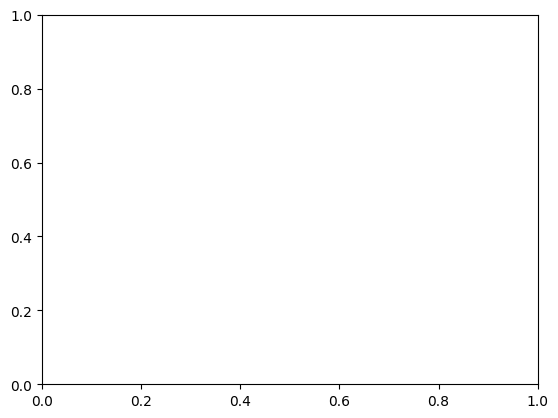

In [ ]:
data_to_tif = fp.fpData()

"""
FR-Gri: 48.84422, 1.95191
FR-Rmv: 48.88514, 2.42222
"""
"""
FR-Gri: L2  Fluxes, 'https://data.icos-cp.eu/licence_accept?ids=%5B%22mAl0uywRaIcP-maLY7cJ3Q_U%22%5D'
FR-Rmv: NRT Fluxes, 'https://citydata.icos-cp.eu/licence_accept?ids=%5B%22kbutdO3tisiqFQdtAfSjb6ow%22%5D'
"""

data_to_tif.direct_path = 'sample/output/from_data_portal/FR-Gri/FR-Gri_footprint_{}.tif'
data_to_tif.data = fp.get_data_from_url(
    'https://data.icos-cp.eu/licence_accept?ids=%5B%22mAl0uywRaIcP-maLY7cJ3Q_U%22%5D', na_values=[-9999]).dropna(subset=['WS', 'WD'])

for d, data in data_to_tif.data.groupby('TIMESTAMP_END'):
    print(d, '<'+'-'*15, ' '*10, end='\r')
    #if os.path.exists(data_to_tif.direct_path.format(f'{d}')): continue
    this_nc = fp.read_from_data(
        data, by='TIMESTAMP_END', **{'zm': 4, 'z0': None, 'PBLH': 1000, 'latlon': (48.84422, 1.95191)})
    if this_nc is None: continue

    fp.write_to_tif(this_nc, this_nc.footprint.attrs['dx, dy'][0], this_nc.footprint.attrs['dx, dy'][1], data_to_tif.direct_path.format(f'{d}'))
    del this_nc


data -> nc

In [ ]:
import datetime

data_to_nc = fp.fpData()

data_to_nc.direct_path = 'sample/output/data_to_nc/FR-Rmv_footprint_{}.nc'
data_to_nc.data = fp.get_data_from_url(
    'https://citydata.icos-cp.eu/licence_accept?ids=%5B%22kbutdO3tisiqFQdtAfSjb6ow%22%5D', na_values=[-9999])

data_to_nc.sitename = 'Paris-Romainville'

for d, data in data_to_nc.data.groupby(pd.to_datetime(data_to_nc.data['TIMESTAMP_END'], format='%Y%m%d%H%M').dt.date):
    print(d, '<'+'-'*15)

    #data_to_nc.FP, _, data_to_nc.parameter = fp.read_from_data(
    #    data, by='TIMESTAMP_END', **{'zm': 50, 'z0': 1, 'PBLH': 1000, 'latlon': (48.88514, 2.42222)})
    #data_to_nc.loc = data_to_nc.parameter['loc']
    #data_to_nc.crs = data_to_nc.parameter['crs']

    this_nc = fp.read_from_data(
        data, by='TIMESTAMP_END', **{'zm': 50, 'z0': 1, 'PBLH': 1000, 'latlon': (48.88514, 2.42222)})

    this_nc.attrs.update({'Title': f'Diurnal Footprints for {data_to_nc.sitename} at 30-min resolution',
            'Creation_Date': datetime.datetime.now().strftime('%d-%b-%Y'),
            #'Contact': 'Pedro Coimbra and Benjamin Loubet at ECOSYS, INRAE, AgroParisTech, Université Paris-Saclay, Palaiseau, France, pedro-henrique.herig-coimbra@inrae.fr and benjamin.loubet@inrae.fr',
            #'Aknowledgement': 'This is the continuation of the work from Betty Molinier and Natascha Kljun, Centre for Environmental and Climate Science, Lund University, betty.molinier@cec.lu.se and natascha.kljun@cec.lu.se',
            #'Conventions': 'CF-1.8',
            #'Creator': 'Betty Molinier¹ (ORCID: 0000-0002-7212-4120), Natascha Kljun¹ (ORCID: 0000-0001-9650-2184), Pedro Coimbra² (ORCID: 0009-0008-6845-8735) and Benjamin Loubet² (ORCID: 0000-0001-8825-8775).\n1 Centre for Environmental and Climate Science, Lund University, Sweden.\n2 ECOSYS, INRAE, AgroParisTech, Université Paris-Saclay, Palaiseau, France',
            #'Institution': 'Centre for Environmental and Climate Science, Lund University, Lund, Sweden',
            'Source': 'Ecosystem Thematic Centre (2024). ETC NRT Fluxes, Romainville, 2023-02-13–2024-04-30, ICOS Cities, https://hdl.handle.net/11676/ML3hTCCg5neiu2yw_HUF7AkW; Hersbach, H., et al. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47 (Accessed on 05-May-2024)',
            #'Model_Used': 'FFP, Kljun et al. (2015), doi:10.5194/gmd‐8‐3695‐2015',
            'Summary': f'This file contains flux footprints for the {data_to_nc.sitename} flux tower in France at 30-minute temporal resolution. The name of the file includes the date of all footprints contained.',
            'Subjects': 'Flux footprints, atmospheric modelling, urban flux, ICOS Cities',
            #'Coordinate_Reference_System': data_to_nc.crs.to_string(), #'WGS 84',
            #'crs_projection4': data_to_nc.crs.to_proj4(), #'+proj=tmerc +lat_0=48.88514 +lon_0=2.42222 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
            #'crs_wkt': data_to_nc.crs.to_wkt(), #'PROJCS["WGS_1984_Transverse_Mercator",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",48.885140],PARAMETER["central_meridian",2.422220],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]',
            #'Variables': 'Time, X, Y, Boundary Layer Height Quality Flag, Footprint Climatology',
            'Tower_Location_Latitude': np.float64(48.88514),
            'Tower_Location_Longitude': np.float64(2.42222),
            'Tower Height (m)': np.float64(102.5),
            #'Frequency': '30 min'
            })

    fp.write_to_nc(this_nc, data_to_nc.direct_path.format(f'{d.strftime('%y%m%d')}'))#, attrs=data_to_nc.attrs)
    del this_nc


2023-02-14 <---------------
Columns zm not found in data.
Columns z0 not found in data.
Columns PBLH not found in data.
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
No footprint calculated
2023-02-15 <---------------
Columns zm not found in data.
Columns z0 not found in data.
Columns PBLH not found in data.
No footprint calculated
No footprint calculated
No footprint calculated
2023-02-16 <---------------
Columns zm not found in data.
Columns z0 not found in data.
Columns PBLH not found in data.
No footprint calculated
2023-02-17 <---------------
Columns zm not found in data.
Columns z0 not found in data.
Columns PBLH not found in data.
2023-02-18 <---------------
Columns zm not found in data.
Columns z0 not found in data.
Columns PBLH not found in data.
2023-02-19 <---------------
Columns zm not found in data.
Columns z0 not found in data.


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002145B4C1F40>>
Traceback (most recent call last):
  File "c:\Users\phherigcoimb\Anaconda3\envs\fpaddon\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\phherigcoimb\Anaconda3\envs\fpaddon\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


MemoryError: Unable to allocate 1.13 GiB for an array with shape (38, 2001, 2001) and data type float64